[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-1/agent-memory.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239417-lesson-7-agent-with-memory)

# Agent memory

## Review

Previously, we built an agent that can:

* `act` - let the model call specific tools
* `observe` - pass the tool output back to the model
* `reason` - let the model reason about the tool output to decide what to do next (e.g., call another tool or just respond directly)

![Screenshot 2024-08-21 at 12.45.32 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab7453080e6802cd1703_agent-memory1.png)

## Goals

Now, we're going extend our agent by introducing memory.

In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_google_genai langchain_core langgraph

In [2]:
from google.colab import userdata
GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

In [3]:
from google.colab import userdata
LANGCHAIN_API_KEY = userdata.get('LANGCHAIN_API_KEY')

This follows what we did previously.

In [4]:
from langchain_google_genai import ChatGoogleGenerativeAI

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash", api_key = GEMINI_API_KEY)
llm_with_tools = llm.bind_tools(tools)

In [5]:
from langgraph.graph import MessagesState
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState) -> MessagesState:
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

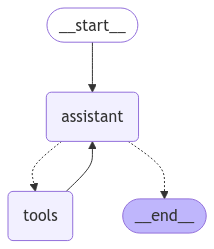

In [6]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display
from langgraph.graph.state import CompiledStateGraph

# Graph
builder: StateGraph = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph: CompiledStateGraph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

## Memory

Let's run our agent, as before.

In [8]:
messages = [HumanMessage(content="Add 3 and 4.")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (2e7d6053-1ee3-494d-ba83-b61f06227e66)
 Call ID: 2e7d6053-1ee3-494d-ba83-b61f06227e66
  Args:
    a: 3.0
    b: 4.0
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The answer is 7.


Now, let's multiply by 2!

In [9]:
messages = [HumanMessage(content="Multiply that by 2.")]
messages = react_graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply that by 2.
================================== Ai Message ==================================

Please provide me with the number you want to multiply by 2.


We don't retain memory of 7 from our initial chat!

This is because [state is transient](https://github.com/langchain-ai/langgraph/discussions/352#discussioncomment-9291220) to a single graph execution.

Of course, this limits our ability to have multi-turn conversations with interruptions.

We can use [persistence](https://langchain-ai.github.io/langgraph/how-tos/persistence/) to address this!

LangGraph can use a checkpointer to automatically save the graph state after each step.

This built-in persistence layer gives us memory, allowing LangGraph to pick up from the last state update.

One of the easiest checkpointers to use is the `MemorySaver`, an in-memory key-value store for Graph state.

All we need to do is simply compile the graph with a checkpointer, and our graph has memory!

# Transient State vs. Steady State

In computing and system behavior, we often encounter two states: transient and steady.

1. **Transient State**:
   - **Definition**: Transient state refers to the moments right after a change occurs. It's a temporary, dynamic condition.
   - **Example**: When you start a new chat session, your memory is transient—you're catching up, refreshing your context, and getting back into the conversation groove.

2. **Steady State**:
   - **Definition**: Steady state represents a stable, predictable condition. It's when a system settles into an equilibrium.
   - **Example**: As our chat progresses and we remember details from earlier conversations, we move toward a steady state.

Remember, in a single chat session (or graph execution), we experience both transient and steady states. Each interaction contributes to our overall understanding.



In [7]:
from langgraph.checkpoint.memory import MemorySaver
memory: MemorySaver = MemorySaver()
react_graph_memory: CompiledStateGraph = builder.compile(checkpointer=memory)

When we use memory, we need to specify a `thread_id`.

This `thread_id` will store our memory location of graph states collection.

Here is a cartoon:

* The checkpointer write the state at every step of the graph
* These checkpoints are saved in a thread
* We can access that thread in the future using the `thread_id`

![state.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e0e9f526b41a4ed9e2d28b_agent-memory2.png)

![state.png](https://github.com/panaversity/learn-agentic-ai-fundamentals/blob/main/03_langchain_ecosystem/langgraph/course-notebooks/module-1/image.png)


In [8]:
# Specify a thread
config1 = {"configurable": {"thread_id": "1"}}


In [8]:


# Specify an input
messages = [HumanMessage(content="Add 3 and 4.")]

# Run
messages = react_graph_memory.invoke({"messages": messages},config1)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (40401d12-dd4a-4d2f-8898-930c001a5572)
 Call ID: 40401d12-dd4a-4d2f-8898-930c001a5572
  Args:
    a: 3.0
    b: 4.0
================================= Tool Message =================================
Name: add

7
================================== Ai Message ==================================

The answer is 7.


If we pass the same `thread_id`, then we can proceed from the previously logged state checkpoint!

In this case, the above conversation is captured in the thread.

The `HumanMessage` we pass (`"Multiply that by 2."`) is appended to the above conversation.

So, the model now know that `that` refers to the `The sum of 3 and 4 is 7.`.

In [9]:
messages = [HumanMessage(content="Multiply that by 2.")]
messages = react_graph_memory.invoke({"messages": messages}, config1)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply that by 2.
================================== Ai Message ==================================

Please provide me with the number you would like to multiply by 2.


## LangGraph Studio

--

**⚠️ DISCLAIMER**

*Running Studio currently requires a Mac. If you are not using a Mac, then skip this step.*

--

Load the `agent` in the UI, which uses `module-1/studio/agent.py` set in `module-1/studio/langgraph.json`.